In [2]:
!pip install 'zarr<3'
!pip install timm
!pip install imagecodecs --user

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached imagecodecs-2026.1.14-cp311-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (20 kB)
Using cached imagecodecs-2026.1.14-cp311-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (24.7 MB)

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [37]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


<tifffile.TiffFile 'ch0000_dapi.ome.tif'> OME series cannot read multi-file pyramids
/tmp/ipykernel_1126/4166643758.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


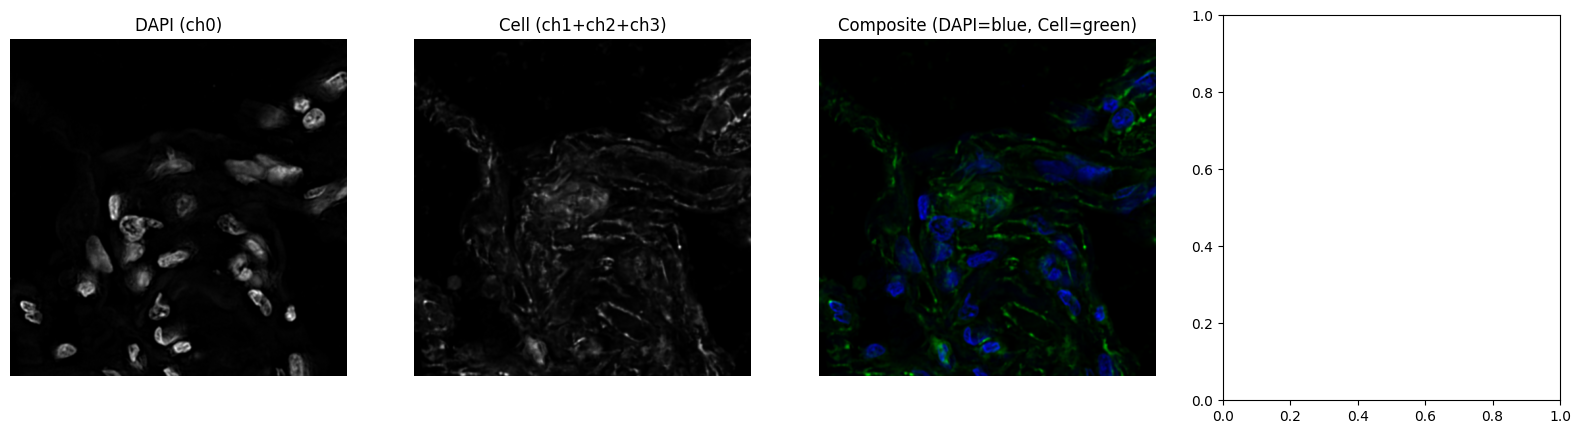

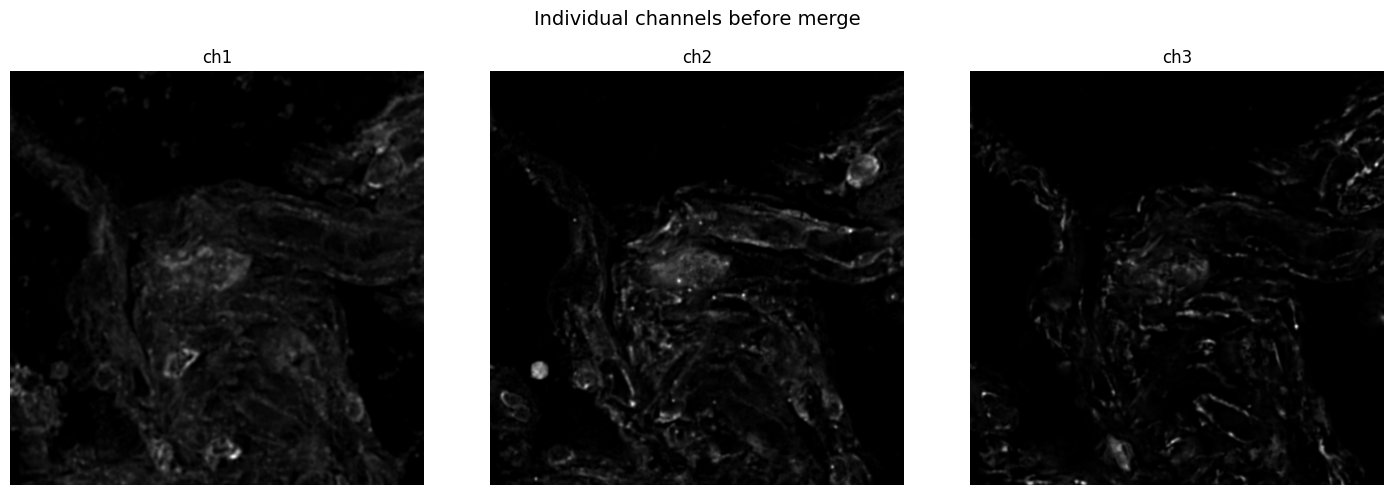

In [39]:
import tifffile as tiff
import zarr
import numpy as np
import matplotlib.pyplot as plt

path = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/Lung_Anthracosis/output-XETG00522__0057986__Region_1__20251203__234028/morphology_focus/ch0000_dapi.ome.tif"

y, x, ps = 11000, 20000, 512

with tiff.TiffFile(path) as tif:
    store = tif.aszarr()
    z = zarr.open(store, mode="r")
    if isinstance(z, zarr.hierarchy.Group):
        z = z["0"]
    patch = np.array(z[:, y:y+ps, x:x+ps])

# ch0 = DAPI, ch1-3 merged = cell
dapi = patch[0].astype(float)
cell = patch[1:].sum(axis=0).astype(float)  # sum ch1+ch2+ch3

# normalize to [0,1]
dapi_norm = dapi / dapi.max() if dapi.max() > 0 else dapi
cell_norm = cell / cell.max() if cell.max() > 0 else cell

# composite: DAPI blue, cell green
composite = np.stack([
    np.zeros_like(dapi_norm),  # R
    cell_norm,                  # G
    dapi_norm                   # B
], axis=-1)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(dapi_norm, cmap="gray")
axes[0].set_title("DAPI (ch0)")
axes[0].axis("off")

axes[1].imshow(cell_norm, cmap="gray")
axes[1].set_title("Cell (ch1+ch2+ch3)")
axes[1].axis("off")

axes[2].imshow(composite)
axes[2].set_title("Composite (DAPI=blue, Cell=green)")
axes[2].axis("off")

# also show individual ch1-3 for reference
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
names = ["ch1", "ch2", "ch3"]
for i in range(3):
    axes2[i].imshow(patch[i+1], cmap="gray")
    axes2[i].set_title(names[i])
    axes2[i].axis("off")
fig2.suptitle("Individual channels before merge", fontsize=14)
fig2.tight_layout()
fig2.savefig("ch1_ch2_ch3_individual.png", dpi=150)

plt.tight_layout()
plt.savefig("dapi_cell_composite.png", dpi=150)
plt.show()

In [40]:
import pandas as pd
import numpy as np

nuc_path = "/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest/inference_dsp/old_xeinum/defult_xenium/nucleus_boundaries.parquet"

nuc_df = pd.read_parquet(nuc_path)
print("Shape:", nuc_df.shape)
print("\nColumns:", nuc_df.columns.tolist())
print("\nFirst few rows:")
print(nuc_df.head())
print("\nDtypes:")
print(nuc_df.dtypes)
print("\nBasic stats:")
print(nuc_df.describe())

Shape: (27562936, 4)

Columns: ['cell_id', 'vertex_x', 'vertex_y', 'label_id']

First few rows:
      cell_id     vertex_x    vertex_y  label_id
0  aaaaaalb-1  5309.737793  682.762512         1
1  aaaaaalb-1  5309.312500  683.187500         1
2  aaaaaalb-1  5308.250000  684.037537         1
3  aaaaaalb-1  5308.250000  684.250000         1
4  aaaaaalb-1  5307.825195  684.887512         1

Dtypes:
cell_id      object
vertex_x    float32
vertex_y    float32
label_id      int64
dtype: object

Basic stats:
           vertex_x      vertex_y      label_id
count  2.756294e+07  2.756294e+07  2.756294e+07
mean   5.811241e+03  1.338899e+04  5.552328e+05
std    2.398088e+03  5.716727e+03  3.212387e+05
min    2.443750e+01  2.018750e+01  1.000000e+00
25%    4.087438e+03  9.048888e+03  2.765870e+05
50%    5.898363e+03  1.359044e+04  5.548720e+05
75%    7.783238e+03  1.765875e+04  8.332830e+05
max    1.151261e+04  2.382529e+04  1.114000e+06


<tifffile.TiffFile 'ch0000_dapi.ome.tif'> OME series cannot read multi-file pyramids


Patch in microns: x=[4250.0, 4358.8], y=[2125.0, 2233.8]
Found 66 nuclei, 1415 points


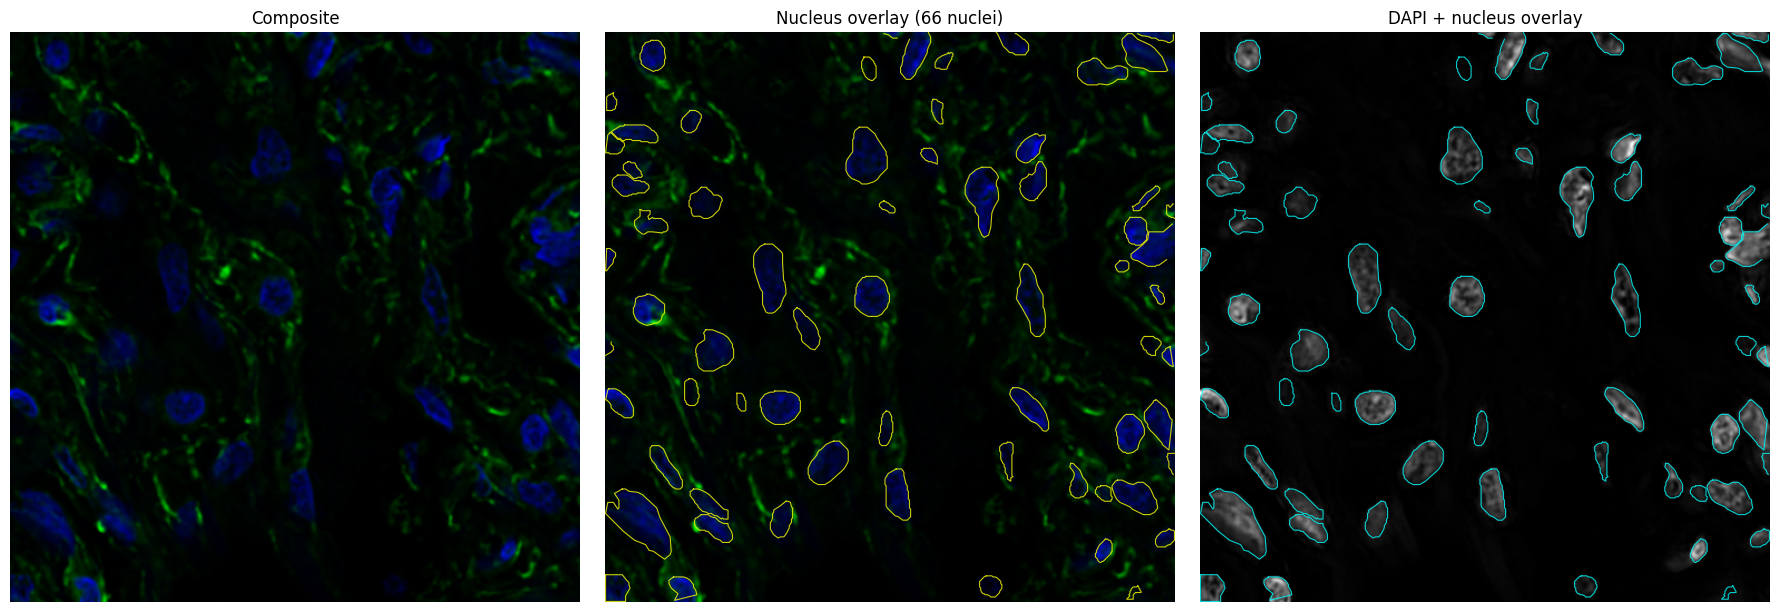

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import zarr

nuc_path = "/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest/inference_dsp/old_xeinum/defult_xenium/nucleus_boundaries.parquet"
nuc_df = pd.read_parquet(nuc_path)

y, x, ps = 10000, 20000, 512
um_per_px = 0.2125

# patch bounds in microns
x_um = x * um_per_px
y_um = y * um_per_px
ps_um = ps * um_per_px
print(f"Patch in microns: x=[{x_um:.1f}, {x_um+ps_um:.1f}], y=[{y_um:.1f}, {y_um+ps_um:.1f}]")

# vertex_x -> image X (width), vertex_y -> image Y (height)
mask = (nuc_df.vertex_x >= x_um) & (nuc_df.vertex_x < x_um + ps_um) & \
       (nuc_df.vertex_y >= y_um) & (nuc_df.vertex_y < y_um + ps_um)
filtered = nuc_df[mask].copy()
print(f"Found {filtered.cell_id.nunique()} nuclei, {len(filtered)} points")

# convert to patch-local pixel coords
filtered["plot_x"] = (filtered["vertex_x"] - x_um) / um_per_px
filtered["plot_y"] = (filtered["vertex_y"] - y_um) / um_per_px

# Load image
img_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/Lung_Anthracosis/output-XETG00522__0057986__Region_1__20251203__234028/morphology_focus/ch0000_dapi.ome.tif"
with tiff.TiffFile(img_path) as tif:
    store = tif.aszarr()
    z = zarr.open(store, mode="r")
    if isinstance(z, zarr.hierarchy.Group):
        z = z["0"]
    patch = np.array(z[:, y:y+ps, x:x+ps])

dapi = patch[0].astype(float)
dapi_norm = dapi / dapi.max() if dapi.max() > 0 else dapi
cell = patch[1:].sum(axis=0).astype(float)
cell_norm = cell / cell.max() if cell.max() > 0 else cell
composite = np.stack([np.zeros_like(dapi_norm), cell_norm, dapi_norm], axis=-1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(composite)
axes[0].set_title("Composite")
axes[0].axis("off")

# overlay on composite
axes[1].imshow(composite)
for cid, grp in filtered.groupby("cell_id"):
    axes[1].plot(grp["plot_x"].values, grp["plot_y"].values,
                 color="yellow", linewidth=0.8, alpha=0.8)
axes[1].set_title(f"Nucleus overlay ({filtered.cell_id.nunique()} nuclei)")
axes[1].axis("off")

# overlay on DAPI only
axes[2].imshow(dapi_norm, cmap="gray")
for cid, grp in filtered.groupby("cell_id"):
    axes[2].plot(grp["plot_x"].values, grp["plot_y"].values,
                 color="cyan", linewidth=0.8, alpha=0.8)
axes[2].set_title("DAPI + nucleus overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()

<tifffile.TiffFile 'ch0000_dapi.ome.tif'> OME series cannot read multi-file pyramids


Nuclei: 125, Cells: 139


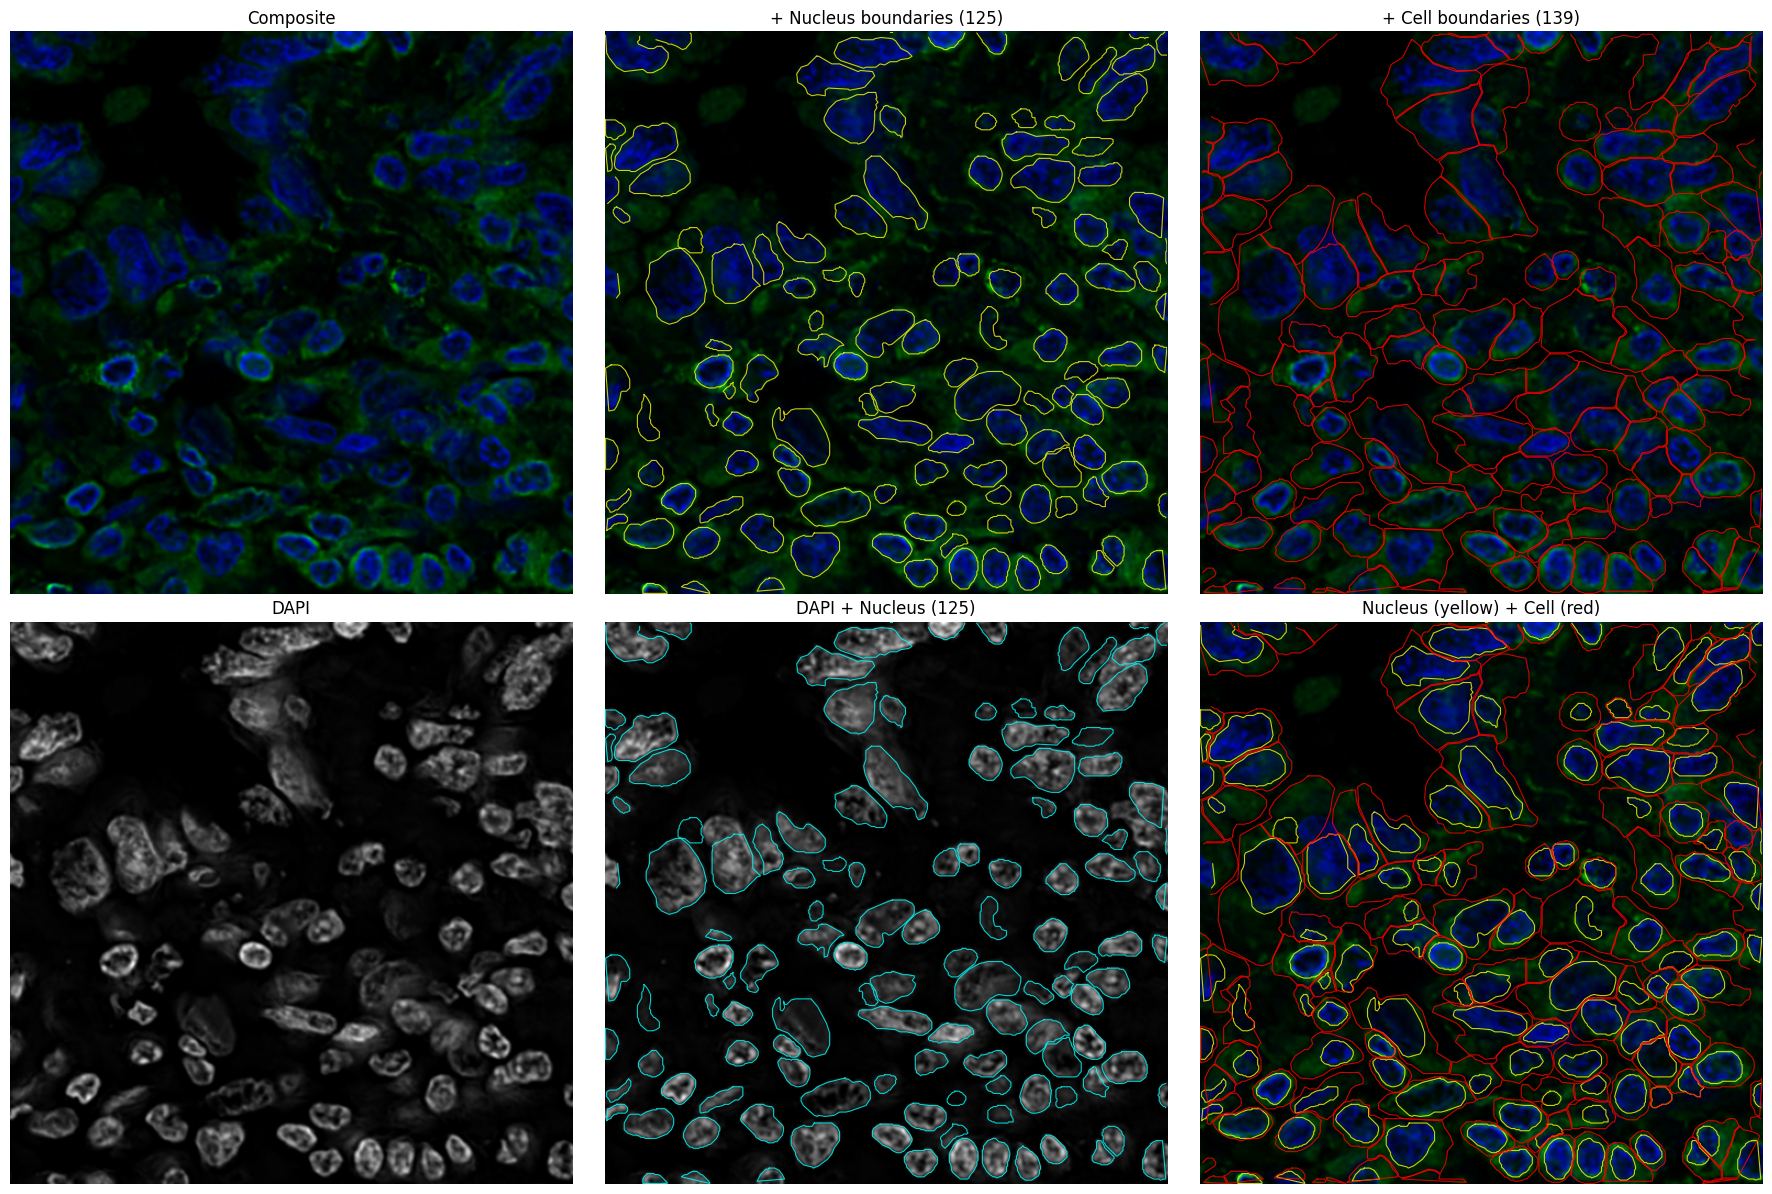

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import zarr

base = "/rsrch9/home/plm/idso_fa1_pathology"
nuc_path = f"{base}/codes/yshokrollahi/vitamin-p-latest/inference_dsp/old_xeinum/defult_xenium/nucleus_boundaries.parquet"
cells_path = f"{base}/codes/yshokrollahi/vitamin-p-latest/inference_dsp/old_xeinum/defult_xenium/cell_boundaries.parquet"

nuc_df = pd.read_parquet(nuc_path)
cells_df = pd.read_parquet(cells_path)

y, x, ps = 50000, 25000, 512
um_per_px = 0.2125

x_um = x * um_per_px
y_um = y * um_per_px
ps_um = ps * um_per_px

# Filter nuclei
nuc_mask = (nuc_df.vertex_x >= x_um) & (nuc_df.vertex_x < x_um + ps_um) & \
           (nuc_df.vertex_y >= y_um) & (nuc_df.vertex_y < y_um + ps_um)
nuc_filtered = nuc_df[nuc_mask].copy()
nuc_filtered["plot_x"] = (nuc_filtered["vertex_x"] - x_um) / um_per_px
nuc_filtered["plot_y"] = (nuc_filtered["vertex_y"] - y_um) / um_per_px

# Filter cells — same columns as nucleus_boundaries
cells_mask = (cells_df.vertex_x >= x_um) & (cells_df.vertex_x < x_um + ps_um) & \
             (cells_df.vertex_y >= y_um) & (cells_df.vertex_y < y_um + ps_um)
cells_filtered = cells_df[cells_mask].copy()
cells_filtered["plot_x"] = (cells_filtered["vertex_x"] - x_um) / um_per_px
cells_filtered["plot_y"] = (cells_filtered["vertex_y"] - y_um) / um_per_px

print(f"Nuclei: {nuc_filtered.cell_id.nunique()}, Cells: {cells_filtered.cell_id.nunique()}")

# Load image
img_path = f"{base}/TIER1/paul-xenium/Lung_Anthracosis/output-XETG00522__0057986__Region_1__20251203__234028/morphology_focus/ch0000_dapi.ome.tif"
with tiff.TiffFile(img_path) as tif:
    store = tif.aszarr()
    z = zarr.open(store, mode="r")
    if isinstance(z, zarr.hierarchy.Group):
        z = z["0"]
    patch = np.array(z[:, y:y+ps, x:x+ps])

dapi = patch[0].astype(float)
dapi_norm = dapi / dapi.max() if dapi.max() > 0 else dapi
cell_ch = patch[1:].sum(axis=0).astype(float)
cell_norm = cell_ch / cell_ch.max() if cell_ch.max() > 0 else cell_ch
composite = np.stack([np.zeros_like(dapi_norm), cell_norm, dapi_norm], axis=-1)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: composite versions
axes[0, 0].imshow(composite)
axes[0, 0].set_title("Composite")
axes[0, 0].axis("off")

axes[0, 1].imshow(composite)
for _, grp in nuc_filtered.groupby("cell_id"):
    axes[0, 1].plot(grp["plot_x"].values, grp["plot_y"].values,
                    color="yellow", linewidth=0.8, alpha=0.8)
axes[0, 1].set_title(f"+ Nucleus boundaries ({nuc_filtered.cell_id.nunique()})")
axes[0, 1].axis("off")

axes[0, 2].imshow(composite)
for _, grp in cells_filtered.groupby("cell_id"):
    axes[0, 2].plot(grp["plot_x"].values, grp["plot_y"].values,
                    color="red", linewidth=0.8, alpha=0.8)
axes[0, 2].set_title(f"+ Cell boundaries ({cells_filtered.cell_id.nunique()})")
axes[0, 2].axis("off")

# Row 2: DAPI versions
axes[1, 0].imshow(dapi_norm, cmap="gray")
axes[1, 0].set_title("DAPI")
axes[1, 0].axis("off")

axes[1, 1].imshow(dapi_norm, cmap="gray")
for _, grp in nuc_filtered.groupby("cell_id"):
    axes[1, 1].plot(grp["plot_x"].values, grp["plot_y"].values,
                    color="cyan", linewidth=0.8, alpha=0.8)
axes[1, 1].set_title(f"DAPI + Nucleus ({nuc_filtered.cell_id.nunique()})")
axes[1, 1].axis("off")

# Both overlays together
axes[1, 2].imshow(composite)
for _, grp in nuc_filtered.groupby("cell_id"):
    axes[1, 2].plot(grp["plot_x"].values, grp["plot_y"].values,
                    color="yellow", linewidth=0.8, alpha=0.8)
for _, grp in cells_filtered.groupby("cell_id"):
    axes[1, 2].plot(grp["plot_x"].values, grp["plot_y"].values,
                    color="red", linewidth=0.8, alpha=0.8)
axes[1, 2].set_title("Nucleus (yellow) + Cell (red)")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

<tifffile.TiffFile 'ch0000_dapi.ome.tif'> OME series cannot read multi-file pyramids


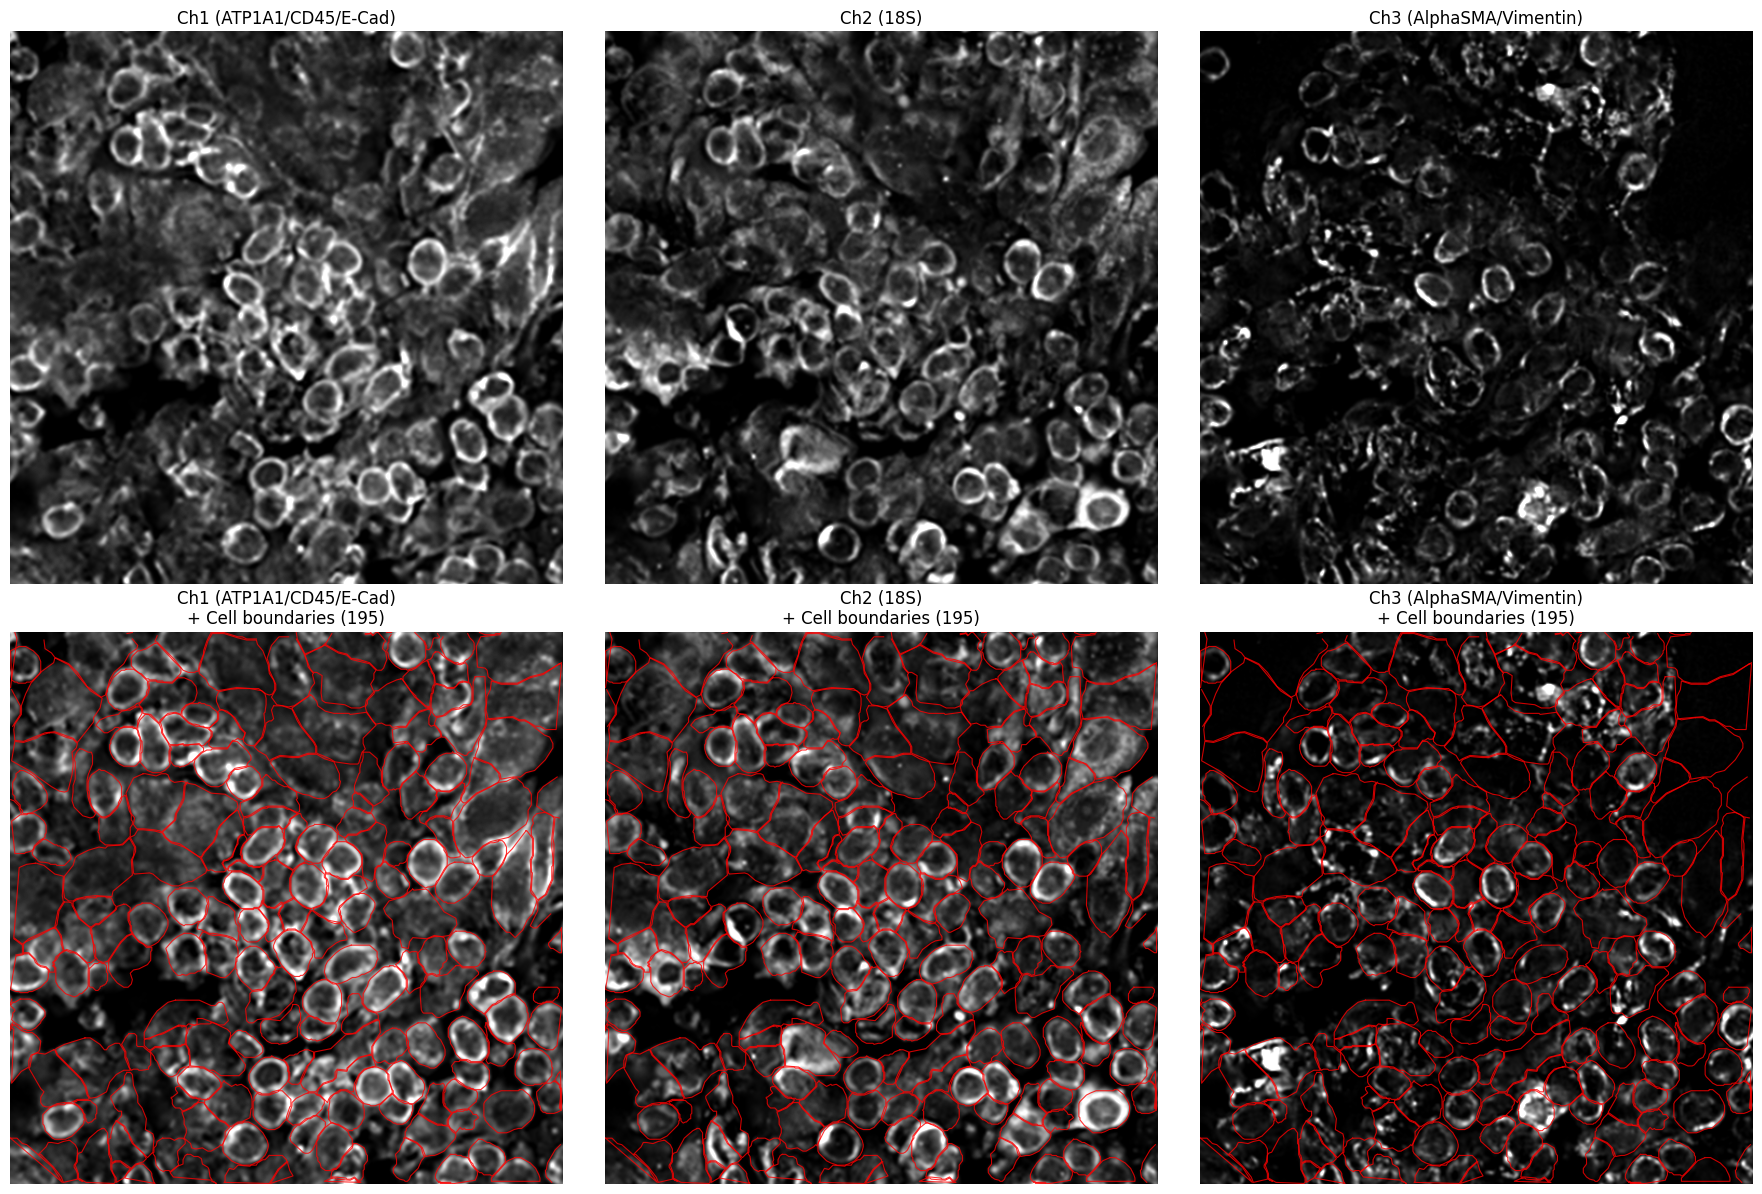

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import zarr

base = "/rsrch9/home/plm/idso_fa1_pathology"
cells_path = f"{base}/codes/yshokrollahi/vitamin-p-latest/inference_dsp/old_xeinum/defult_xenium/cell_boundaries.parquet"
cells_df = pd.read_parquet(cells_path)

y, x, ps = 50000, 23000, 512
um_per_px = 0.2125

x_um = x * um_per_px
y_um = y * um_per_px
ps_um = ps * um_per_px

# Filter cells
cells_mask = (cells_df.vertex_x >= x_um) & (cells_df.vertex_x < x_um + ps_um) & \
             (cells_df.vertex_y >= y_um) & (cells_df.vertex_y < y_um + ps_um)
cells_filtered = cells_df[cells_mask].copy()
cells_filtered["plot_x"] = (cells_filtered["vertex_x"] - x_um) / um_per_px
cells_filtered["plot_y"] = (cells_filtered["vertex_y"] - y_um) / um_per_px

# Load image
img_path = f"{base}/TIER1/paul-xenium/Lung_Anthracosis/output-XETG00522__0057986__Region_1__20251203__234028/morphology_focus/ch0000_dapi.ome.tif"
with tiff.TiffFile(img_path) as tif:
    store = tif.aszarr()
    z = zarr.open(store, mode="r")
    if isinstance(z, zarr.hierarchy.Group):
        z = z["0"]
    patch = np.array(z[:, y:y+ps, x:x+ps])

# ch1, ch2, ch3 are the cell channels — brighten with percentile normalization
def bright_norm(img, pmin=0, pmax=99.5):
    low, high = np.percentile(img, pmin), np.percentile(img, pmax)
    return np.clip((img.astype(float) - low) / (high - low + 1e-8), 0, 1)

ch1 = bright_norm(patch[1])  # ATP1A1/CD45/E-Cadherin
ch2 = bright_norm(patch[2])  # 18S
ch3 = bright_norm(patch[3])  # AlphaSMA/Vimentin

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

ch_names = ["Ch1 (ATP1A1/CD45/E-Cad)", "Ch2 (18S)", "Ch3 (AlphaSMA/Vimentin)"]
channels = [ch1, ch2, ch3]

# Row 1: each channel alone
for i, (ch, name) in enumerate(zip(channels, ch_names)):
    axes[0, i].imshow(ch, cmap="gray")
    axes[0, i].set_title(name, fontsize=12)
    axes[0, i].axis("off")

# Row 2: each channel + cell boundaries overlay
for i, (ch, name) in enumerate(zip(channels, ch_names)):
    axes[1, i].imshow(ch, cmap="gray")
    for _, grp in cells_filtered.groupby("cell_id"):
        axes[1, i].plot(grp["plot_x"].values, grp["plot_y"].values,
                        color="red", linewidth=0.8, alpha=0.8)
    axes[1, i].set_title(f"{name}\n+ Cell boundaries ({cells_filtered.cell_id.nunique()})", fontsize=12)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [52]:
import tifffile as tiff

# Save patch as multi-channel TIFF
patch_tiff_path = "patch_50000_23000.tif"
tiff.imwrite(patch_tiff_path, patch)  # patch is already (C, Y, X)

## flex

In [44]:
import torch
from vitaminp import VitaminPFlex
from vitaminp.inference import ChannelConfig, WSIPredictor
# Setup model
device = 'cuda'
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold21_best.pth", map_location=device))
model.eval()

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Install with: pip install cupy-cuda12x  (or cupy-cuda11x depending on your CUDA version)
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]


VitaminPFlex(
  (backbone): DINOv2Backbone(
    (dinov2): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): M

In [60]:
from vitaminp.inference.channel_config import ChannelConfig
from vitaminp.inference import WSIPredictor

config = ChannelConfig(
    nuclear_channel=0,
    membrane_channel=[1],
    membrane_combination='max',
    channel_names={0: 'DAPI', 1: 'ATP1A1_CD45_ECad', 2: '18S', 3: 'AlphaSMA_Vimentin'}
)

predictor = WSIPredictor(
    model=model,
    device='cuda',
    patch_size=512,
    overlap=64,
    target_mpp=0.263,
    magnification=40,
    mif_channel_config=config
)

results = predictor.predict(
    wsi_path="patch_50000_23000.tif",
    output_dir='results_patch_onlycd45',
    branch='mif_cell',
    filter_tissue=False,
    clean_overlaps=True,
    save_masks=False,
    save_geojson=True,
    detection_threshold=0.5,
    min_area_um=5.0,
    simplify_epsilon=None,
    coord_precision=None,
    save_parquet=True,
)

print(f"✅ Found {results['num_detections']} nuclei in {results['processing_time']:.2f}s")
print(f"   Output saved to: {results['output_dir']}")

2026-02-01 17:47:41 - WSIPredictor - INFO - WSIPredictor initialized:
2026-02-01 17:47:41 - WSIPredictor - INFO -   Device: cuda
2026-02-01 17:47:41 - WSIPredictor - INFO -   Model type: VitaminPFlex (single-modality)
2026-02-01 17:47:41 - WSIPredictor - INFO -   Patch size: 512
2026-02-01 17:47:41 - WSIPredictor - INFO -   Overlap: 64
2026-02-01 17:47:41 - WSIPredictor - INFO -   Magnification: 40
2026-02-01 17:47:41 - WSIPredictor - INFO -   MIF channels: Nuclear: DAPI, Membrane: max(ATP1A1_CD45_ECad)
2026-02-01 17:47:41 - WSIPredictor - INFO -    Using default MPP: 0.2630 μm/px
2026-02-01 17:47:41 - WSIPredictor - INFO - 🔍 Resolution matching:
2026-02-01 17:47:41 - WSIPredictor - INFO -    WSI MPP: 0.2630 μm/px
2026-02-01 17:47:41 - WSIPredictor - INFO -    Model training MPP: 0.2630 μm/px
2026-02-01 17:47:41 - WSIPredictor - INFO -    Scale factor: 1.00x
2026-02-01 17:47:41 - WSIPredictor - INFO -    Min area filter: 5.0 μm² = 72 pixels²
2026-02-01 17:47:41 - WSIPredictor - INFO - 

Output: shape=(2, 512, 512), dtype=float32, range=[0.000, 0.026]
   Scanning 1x1 tile grid...


Processing tiles:   0%|          | 0/1 [00:00<?, ?it/s]

⚠ GPU requested but CuPy not available, using CPU


Processing tiles: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]
2026-02-01 17:47:41 - WSIPredictor - INFO -    DEBUG: Actually processed 1 tiles out of 1 available
2026-02-01 17:47:41 - WSIPredictor - INFO -    ✓ Extracted 179 instances from tiles (before cleaning)
2026-02-01 17:47:41 - WSIPredictor - INFO -    🔍 DEBUG: Tile configuration:
2026-02-01 17:47:41 - WSIPredictor - INFO -       - Tile size: 512px
2026-02-01 17:47:41 - WSIPredictor - INFO -       - Overlap: 64px
2026-02-01 17:47:41 - WSIPredictor - INFO -       - Grid: 1x1 tiles
2026-02-01 17:47:41 - WSIPredictor - INFO -    🔍 DEBUG: Cells near tile boundaries (within 64px): 69
2026-02-01 17:47:41 - WSIPredictor - INFO -    🔍 DEBUG: Potential overlap rate: 38.5%
2026-02-01 17:47:41 - WSIPredictor - INFO - 🧹 Cleaning overlapping instances at tile boundaries...
2026-02-01 17:47:41 - WSIPredictor - INFO -    🔍 DEBUG: Total cells before cleaning: 179
2026-02-01 17:47:41 - WSIPredictor - INFO -    🔍 DEBUG: Edge cells found: 0
2026

✓ Exported 179 instances to Parquet
✅ Found 179 nuclei in 0.48s
   Output saved to: results_patch_onlycd45
